# Context of Mutations

### Skylar Wyant - 2019/04/18

This notebook explores the indels in the FN30 and BL107.

## Importing Data

In [1]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.2.0


In [136]:
chrom = 'Chr01'
dataset = '107'
num_samps = 107
file = '/panfs/roc/groups/9/morrellp/shared/Projects/Context_Of_Mutations/FN30cat/Variant_Recalibrator/FN30CAT_' + dataset + '_indels.vcf'

In [137]:
allel.vcf_to_hdf5(file,
                  '/panfs/roc/groups/9/morrellp/shared/Projects/Context_Of_Mutations/FN30cat/Variant_Recalibrator/FN30CAT_' + dataset + '_indels_' + chrom + '.h5',
                  fields='*', 
                  region=chrom, 
                  overwrite=True)

In [138]:
callset = h5py.File('/panfs/roc/groups/9/morrellp/shared/Projects/Context_Of_Mutations/FN30cat/Variant_Recalibrator/FN30CAT_' + dataset + '_indels_' + chrom + '.h5', mode='r')

In [139]:
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'AC'],
                                     index='POS')

In [140]:
callset = allel.read_vcf(file)
gt = allel.GenotypeArray(callset['calldata/GT'])
index = gt.n_samples
samps = callset['samples']

In [141]:
stats = np.ndarray(shape=(num_samps,5), dtype=np.int32)
for i in range(0, index):
        stats.itemset((i, 0), i+1)
        #print(str(i+1) + ': ' + str(samps[i]))
        stats.itemset((i, 1), gt[:,i].count_missing())
        stats.itemset((i, 2), gt[:,i].count_het())
        stats.itemset((i, 3), gt[:,i].count_hom_alt())
        stats.itemset((i, 4), gt[:,i].count_het() + gt[:,i].count_hom_alt())
        #print(str(toprint[0]) + '\t' + str(toprint[1]) + '\t' + str(toprint[2]) + '\t' + str(toprint[3]) + '\t' + str(toprint[4]))

## Analysis

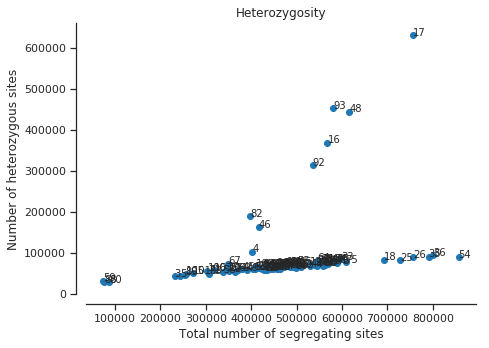

In [142]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.despine(ax=ax, offset=10)
ax.scatter(stats[:,4], stats[:,2])
#ax.set_xlim(0, 3000000)
#ax.set_ylim(0, 1000000)
ax.set_xlabel('Total number of segregating sites')
ax.set_ylabel('Number of heterozygous sites')
ax.set_title('Heterozygosity')
for i, txt in enumerate(stats[:,0]):
    ax.annotate(txt, (stats[i,4], stats[i,2]))

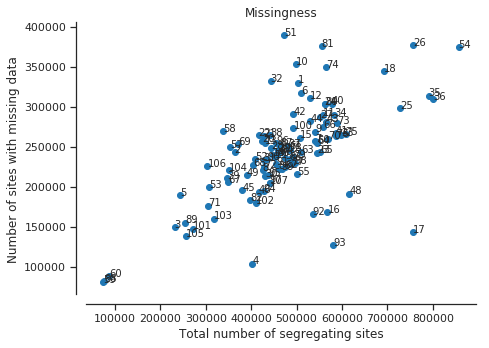

In [143]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.despine(ax=ax, offset=10)
ax.scatter(stats[:,4], stats[:,1])
#ax.set_xlim(0, 3000000)
#ax.set_ylim(0, 300000)
ax.set_xlabel('Total number of segregating sites')
ax.set_ylabel('Number of sites with missing data')
ax.set_title('Missingness')
for i, txt in enumerate(stats[:,0]):
    ax.annotate(txt, (stats[i,4], stats[i,1]))

In [144]:
def plot_windowed_variant_density(pos, window_size, title=None):
    
    # setup windows 
    bins = np.arange(0, pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)

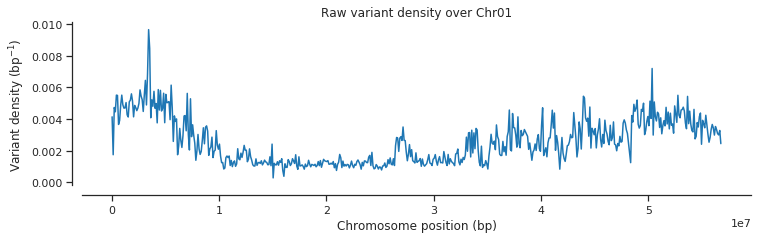

In [145]:
title = 'Raw variant density over ' + chrom
pos = variants['POS'][:]
plot_windowed_variant_density(pos, window_size=100000, title=title)

In [146]:
def plot_variant_hist(x, f, bins=30):
    #x = variants[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    if f == 'DP':
        ax.set_xlim(0, 5000)
    if f == 'MQ':
        ax.set_xlim(0, 100)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)

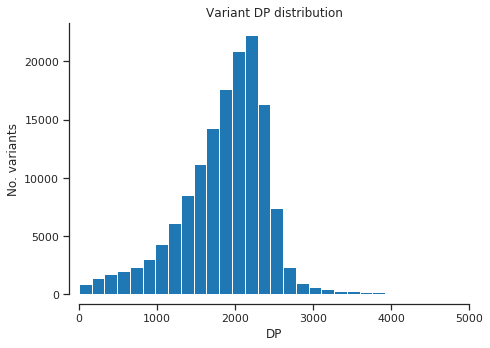

In [147]:
DP = variants['DP'][:]
plot_variant_hist(DP, 'DP', bins=3000)

In [172]:
np.percentile(variants['DP'][:], 98)

2991.0

In [148]:
MQ = variants['MQ'][:]
cleanMQ = MQ[np.isfinite(MQ)]
#cleanMQ[:]

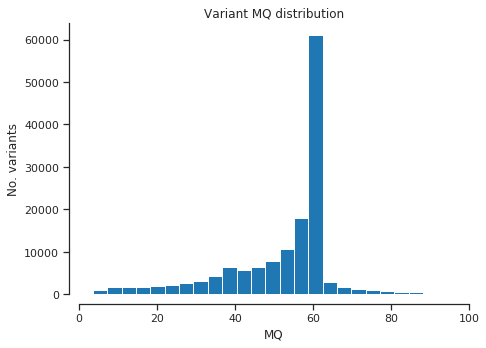

In [149]:
plot_variant_hist(cleanMQ, 'MQ', bins=100)

/home/morrellp/public/Software/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/morrellp/public/Software/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


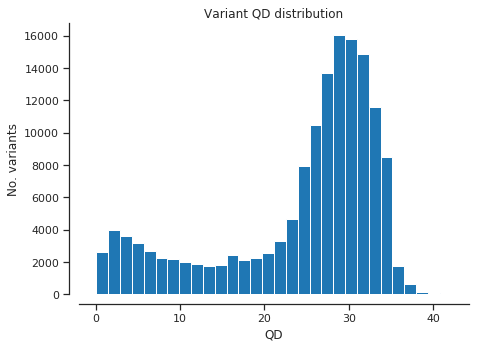

In [150]:
QD = variants['QD'][:]
plot_variant_hist(QD, 'QD')

In [151]:
AC = variants['AC'][:]
rows = (AC != -1).sum(1)
#rows

In [152]:
biallelic = ((0 < rows) & (rows < 2)).sum()
triallelic = ((1 < rows) & (rows < 3)).sum()
quadrallelic = ((2 < rows) & (rows < 4)).sum()

In [153]:
print('Total: ' + str(np.size(rows,0)) + '\nBiallelic: ' + str(biallelic) + 
      '\nTriallic: ' + str(triallelic) + '\nQuadrallelic: ' + str(quadrallelic))

Total: 146676
Biallelic: 114655
Triallic: 23455
Quadrallelic: 8566


In [154]:
new_file = '/panfs/roc/groups/9/morrellp/shared/Projects/Context_Of_Mutations/FN30cat/Variant_Recalibrator/FN30CAT_' + dataset + '_indels_biallelic.vcf'
allel.vcf_to_hdf5(new_file,
                  '/panfs/roc/groups/9/morrellp/shared/Projects/Context_Of_Mutations/FN30cat/Variant_Recalibrator/FN30CAT_' + dataset + '_indels_biallelic' + chrom + '.h5',
                  fields='*', 
                  region=chrom, 
                  overwrite=True)

In [155]:
new_callset = h5py.File('/panfs/roc/groups/9/morrellp/shared/Projects/Context_Of_Mutations/FN30cat/Variant_Recalibrator/FN30CAT_' + dataset + '_indels_biallelic' + chrom + '.h5', mode='r')
new_variants = allel.VariantChunkedTable(new_callset['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'AC'],
                                     index='POS')

In [156]:
calldata = new_callset['calldata/GT']
genotypes = allel.GenotypeChunkedArray(calldata)
ac = genotypes.count_alleles(max_allele=3)
is_biallelic = ac.is_biallelic_01()[:]
ac_bi = ac.compress(is_biallelic, axis=0)[:, :2]
ac_bi_alt = ac_bi[:, 1]

In [157]:
print(str((len(is_biallelic) - len(ac_bi))/len(is_biallelic)*100) + 
    '% of variants are called as the alternative allele 100% of the time')

1.1861671972439056% of variants are called as the alternative allele 100% of the time


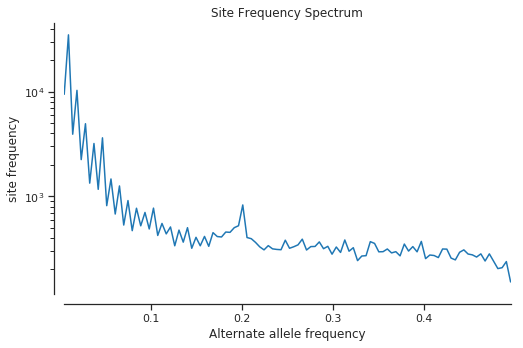

In [158]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.despine(ax=ax, offset=10)
sfs1 = allel.sfs_folded(ac_bi)
allel.plot_sfs_folded(sfs1, ax=ax, n=num_samps*2)
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 45000)
ax.set_title('Site Frequency Spectrum')
# workaround bug in scikit-allel re axis naming
ax.set_xlabel('Alternate allele frequency');

## Filtering

In [159]:
filter_expression = '(QD > 20) & (MQ > 35) & (DP > 5) & (DP < 3500)'
variant_selection = new_variants.eval(filter_expression)[:]

<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater


In [160]:
print("# remaining: " + str(np.count_nonzero(variant_selection)))

# remaining: 77260


In [161]:
print(str(np.count_nonzero(variant_selection)/len(new_variants)*100) + ' %')

67.384762984606 %


In [162]:
variants_pass = new_variants.compress(variant_selection)
genotypes_pass = genotypes.compress(variant_selection)
ac_pass = genotypes_pass.count_alleles(max_allele=3)
is_biallelic_pass = ac_pass.is_biallelic_01()[:]
ac_bi_pass = ac_pass.compress(is_biallelic_pass, axis=0)[:, :2]
ac_bi_alt_pass = ac_bi_pass[:, 1]
print(str((len(is_biallelic_pass) - len(ac_bi_pass))/len(is_biallelic_pass)*100) + 
    '% of variants are called as the alternative allele 100% of the time')

1.295625161791354% of variants are called as the alternative allele 100% of the time


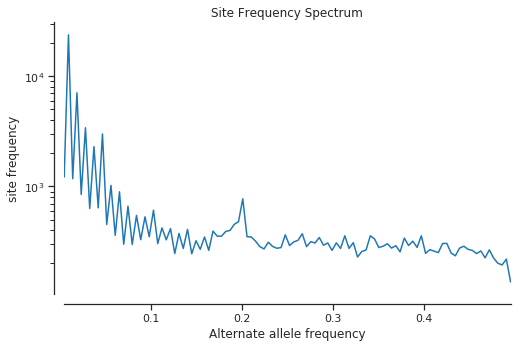

In [163]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.despine(ax=ax, offset=10)
sfs1 = allel.sfs_folded(ac_bi_pass)
allel.plot_sfs_folded(sfs1, ax=ax, n=num_samps*2)
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 45000)
ax.set_title('Site Frequency Spectrum')
# workaround bug in scikit-allel re axis naming
ax.set_xlabel('Alternate allele frequency');

In [164]:
%%bash
jupyter nbconvert  --to=html 'COM_indel_exploration.ipynb'

[NbConvertApp] Converting notebook COM_indel_exploration.ipynb to html
[NbConvertApp] Writing 546334 bytes to COM_indel_exploration.html
